In [82]:
!pip install kneed
from kneed import KneeLocator ##for finding the convergence point on plots

random.seed(0)

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import random
import gym
import numpy as np
import time
from uofgsocsai import LochLomondEnv # load the class defining the custom Open AI Gym problem
import os, sys
from helpers import *

import os, sys
from copy import deepcopy 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import lines
import networkx as nx
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
AIMA_TOOLBOX_ROOT="aima-python-uofg_v20192020b"
sys.path.append(AIMA_TOOLBOX_ROOT)

from search import *
from notebookutils import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens
# Needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")


'''
Concepts learnt and some ideas for code taken from deeplizard.com
Simple agent uses AIMA toolbox codes and  from ARTIFICIAL INTELLIGENCE (H/M) laboratory notebooks.


'''

# RL Agent:
   ## 1) Policy 
   ## 2) qLearningAgent

### Accuracy of RL agent is measured over the testing phase where learning rate is 0

In [83]:
def policy(q_table,env):
    '''
    This function takes a q_table and the env returned by the qLearningAgent to plot the policy
    
    
    '''
    
    
    env.reset()                
                
    if q_table.shape==(16,4):                      # now same for 4X4
        policy_matrix=np.empty((16,1),dtype='U10') #initiallizing the policy matrix
        temp_table=np.empty((16,1),dtype='U10')    #temporary table 16X1
        count=0
        m_table=env.desc.ravel().reshape((16,1))  #m_table contains the env.desc in 16X1
        for x in m_table:                        #for each b'H' in m_table, assign str='H' in the temporary table
            if x==b'H':
                temp_table[count]='Hole'
            elif x==b'G':                      #Goal should be also explicitely shown in the temporary table
                temp_table[count]='Goal'
                
                
            count+=1   #count incremented by 1
            
        count=0 #count reset to 0 so that it can be reused in the below for loops
                
        #print(temp_table.reshape((4,4))) #---debug
        
        
        
        #Now, taking argmax from each state of q_table and storing the 0,1,2,3 in temp_table:
        for state in q_table:
            if temp_table[count]=='Hole' or temp_table[count]=='Goal':  #not changing the Hole and Goal in the temp_table
                count+=1
                
                
                continue  
            
            
            else:
                '''
                Some NON-HOLE states weren't learnt at all, all the 4 columns in those states were 0s. 
                These states wil contain a string: null
                '''
                
                
                if np.allclose(state,np.zeros((1,4))):    #unlearnt states set to 'null'
                    temp_table[count]='null'
                    count+=1
                else:
                
                    temp_table[count]=np.argmax(state)  #states that were learnt
                    count+=1
        #print(temp_table.reshape((4,4)))   #debug
        
        #q_table_transformed=q_table.reshape(4,4) #debug
        
        for i in range(16):
            if temp_table[i]=='Hole' or temp_table[i]=='Goal' or temp_table[i]=='null':
                policy_matrix[i]=temp_table[i]  #explicitely storing hole,goal and nulls
                
                
                continue
            
            
            if temp_table[i]=='0':     #if left
                policy_matrix[i]='<'
            elif temp_table[i]=='1':   #if down
                policy_matrix[i]='down'
            elif temp_table[i]=='2':   #if right
                policy_matrix[i]='>'
            elif temp_table[i]=='3':   #if up
                policy_matrix[i]='^'
        #print(p_table)               #debug
        return policy_matrix.reshape((4,4)), temp_table.reshape((4,4))

In [84]:
def qLearningAgent(problem_id,map_name_base,max_episodes,max_iter_per_episode,exploration_rate,\
                   learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                   reward,reward_hole, is_stochastic, discount_rate):
    '''
    Returns: q_table, accuracy, reward_per_episode, state_df,env. reward_per_episode is the averaged rewards gained
    per 1000 episode, state_df gives the utility of the states for every episode. Accuracy is goal/(goal+hole) under testing phase
    '''
    
    env = LochLomondEnv(problem_id=problem_id, is_stochastic=is_stochastic,\
                        map_name_base=map_name_base, reward_hole=reward_hole,reward=reward)
    
    testing_phase=int(max_episodes-0.3*max_episodes)  # if max_episodes is 100,000 then testing phase will begin at episode 80,000 
    
    start_time=time.time()
    env.reset()
    q_table=np.zeros((env.observation_space.n, env.action_space.n))
    #q_convergence=pd.DataFrame() #a df object to store the Q values of each state (64Xmax_episodes) or (16Xmax_episodes)

    state_df=pd.DataFrame(index=list(range(env.observation_space.n)))

    goal_count=0 #to check how many goals acieved for all episodes combined
    hole_count=0 #to check how many holes the agent fell into for all episodes combined

    episode_count=1
    reward_per_episode=[]
    #rewards_per_100_episodes=[]
    reward_sum=0
    for episodes in range(max_episodes):
        state=env.reset()  #it is 0 and env.reset always returns the initial state in any map be it cartpole or frozenlake
        done=False


        for step in range(max_iter_per_episode):

            #first agent will either explore and then leans towards exploit gradually
            if random.uniform(0,1) > exploration_rate:
                #it will exploit
                action=np.argmax(q_table[state,:]) #action will be the max value in the row no (state)


            else:

                #it will explore randomly

                action=env.action_space.sample()

            new_state,reward,done,info=env.step(action) #once agent has decided an action, it will take the step
            #however, due to randomness, the next_state may not be intended.
            #result will be the next state, reward, done or not and some info(some env return info)

            if episodes<testing_phase:

                #learning phase
                q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
                                learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))
                state=new_state
                reward_sum+=reward #summing reward on each step
                if done == True:
                    break




            else:
                #testing phase
                learning_rate=0 #it will stop learning now and move on learned q_table
                q_table[state, action] = q_table[state, action] * (1 - learning_rate) + \
                                learning_rate * (reward + discount_rate * np.max(q_table[new_state, :]))


                state=new_state #after taking the action, environment returned the observation of the next state, and so agent will
                                #go into this state.
                reward_sum+=reward #summing reward on each step

                if done == True and reward==1:
                    goal_count+=1
                    break
                elif done==True and reward==reward_hole:
                    hole_count+=1
                    break

        exploration_rate = min_exploration_rate +(max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate*episodes) #hands-on intelligent agents with OpenAI Gym
        #exploration_rate-=300*min_exploration_rate/max_episodes
        
        state_df[episodes]=np.max(q_table,axis=1)

        
        
        
        '''
        Below is checking every 100 episodes, the average of rewards:
        '''
        
        if episode_count==500:
            reward_per_episode.append(reward_sum/episode_count)
            reward_sum=0
            episode_count=0

        episode_count+=1
        '''
        q_2.append(np.mean(q_table[2]))


        '''

        #reward_per_episode.append(reward_sum) #appending the total reward gained at each episode

    accuracy=(goal_count/(goal_count+hole_count)) *100

    print(f"Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: {accuracy}\n")
    
    
    

        #-------------------------------------------------------------------Time------------------
    end_time=time.time()-start_time
    if q_table.shape==(64,4):
        print("The time it took to train the agent in a 8X8 maze:\n")
        print(time.strftime("%H:%M:%S", time.gmtime(end_time)))
    else:
        print("The time it took to train the agent in a 4X4 maze:\n")
        print(time.strftime("%H:%M:%S", time.gmtime(end_time)))



    return q_table, accuracy, reward_per_episode, state_df,env
        
        
        


In [85]:
accuracy_rl=[] #to be used in bar plots
reward_df=pd.DataFrame()

### Problem ID=0

In [86]:
problem_id=0
map_name_base='4x4-base'
max_episodes=30000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
        
q_table_0, accuracy_rl_0, reward_per_episode_rl_0, state_df_rl_0,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                        reward,reward_hole, is_stochastic, discount_rate)
print(f"\n The accuracy at testing phase is: {accuracy_rl_0}")
print("problem_id: 0, Agent Trained. Below is the policy: \n")
print(policy(q_table_0,env)[0])



Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 98.44444444444444

The time it took to train the agent in a 4X4 maze:

00:00:42

 The accuracy at testing phase is: 98.44444444444444
problem_id: 0, Agent Trained. Below is the policy: 

[['<' '^' '^' '^']
 ['<' 'Hole' '<' 'Hole']
 ['<' 'down' '<' 'Hole']
 ['Goal' '<' '<' 'down']]


In [87]:
accuracy_rl.append(accuracy_rl_0)

reward_df[0]=reward_per_episode_rl_0

## Problem ID :1 

In [88]:
problem_id=1
map_name_base='4x4-base'
max_episodes=30000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
        
q_table_1, accuracy_rl_1, reward_per_episode_rl_1, state_df_rl_1,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                        reward,reward_hole, is_stochastic, discount_rate)

print(f"\n The accuracy at testing phase is: {accuracy_rl_1}")
print("problem_id: 1, Agent Trained. Below is the policy: \n")
print(policy(q_table_1,env)[0])



Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 86.10184567489438

The time it took to train the agent in a 4X4 maze:

00:00:57

 The accuracy at testing phase is: 86.10184567489438
problem_id: 1, Agent Trained. Below is the policy: 

[['<' '^' '^' '^']
 ['<' 'Hole' '<' 'Hole']
 ['^' 'down' '<' 'Hole']
 ['Hole' 'Goal' 'down' 'down']]


In [89]:
accuracy_rl.append(accuracy_rl_1)
reward_df[1]=reward_per_episode_rl_1

## Probem ID: 2

In [90]:
problem_id=2
map_name_base='4x4-base'
max_episodes=30000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
q_table_2, accuracy_rl_2, reward_per_episode_rl_2, state_df_rl_2,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                        reward,reward_hole, is_stochastic, discount_rate)
print("problem_id: 2, Agent Trained. Below is the policy: \n")
print(policy(q_table_2,env)[0])



Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 95.72222222222221

The time it took to train the agent in a 4X4 maze:

00:00:53
problem_id: 2, Agent Trained. Below is the policy: 

[['<' '^' '^' '^']
 ['<' 'Hole' '>' 'Hole']
 ['<' 'down' '<' 'Hole']
 ['Goal' '<' '<' 'down']]


In [91]:
accuracy_rl.append(accuracy_rl_2)
reward_df[2]=reward_per_episode_rl_2

## Problem ID: 3

In [92]:
problem_id=3
map_name_base='4x4-base'
max_episodes=30000
max_iter_per_episode=200
exploration_rate=1
learning_rate=0.1
min_exploration_rate=0.01  #deeplizard.com : to bind exploration_rate between 0.01 and 1
max_exploration_rate=1
exploration_decay_rate=0.001 
reward_hole=-0.1
reward=1
is_stochastic=True
discount_rate=0.99
        
q_table_3, accuracy_rl_3, reward_per_episode_rl_3, state_df_rl_3,env=\
                                        qLearningAgent(problem_id,map_name_base,max_episodes,\
                                                    max_iter_per_episode,exploration_rate,\
                                                    learning_rate,min_exploration_rate,max_exploration_rate,exploration_decay_rate,\
                                                        reward,reward_hole, is_stochastic, discount_rate)
print("The accuracy is : {}".format(accuracy_rl_3))
print("\nproblem_id: 3, Agent Trained. Below is the policy: \n")
print(policy(q_table_3,env)[0])



Accuracy is overall goals achieved wrt total loss at holes AT TESTING PHASE: 79.78604858480054

The time it took to train the agent in a 4X4 maze:

00:01:08
The accuracy is : 79.78604858480054

problem_id: 3, Agent Trained. Below is the policy: 

[['<' '^' '^' '^']
 ['<' 'Hole' '>' 'Hole']
 ['^' 'down' '<' 'Hole']
 ['Hole' '>' 'Goal' 'null']]


In [93]:
accuracy_rl.append(accuracy_rl_3)
reward_df[3]=reward_per_episode_rl_3

### Average reward gained in all 4 problems by RL agent:

In [94]:

avg_reward_rl=np.mean(reward_df.values,1)


The point of convergence for the RL agent is  5500


Text(5500,0.3,'4500')

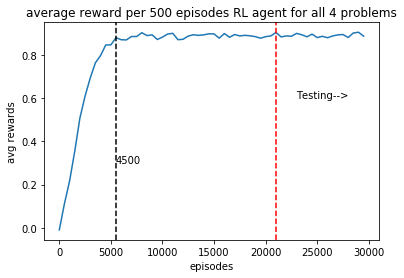

In [95]:
import matplotlib.pyplot as plt


plt.plot(list(range(0,max_episodes,500)),avg_reward_rl)
plt.title("average reward per 500 episodes RL agent for all 4 problems")
plt.xlabel("episodes")
plt.ylabel("avg rewards")

plt.axvline(testing_phase,color='r', linestyle='--')
plt.text(23000,0.6,"Testing-->")

converge_point = KneeLocator(range(0,max_episodes,500), avg_reward_rl, direction='increasing') #knee locator
print("The point of convergence for the RL agent is ",converge_point.knee)
plt.axvline(converge_point.knee,color='k',linestyle='--')
plt.annotate('4500',xy=(converge_point.knee,0.3),xytext=(converge_point.knee,0.3))


## Individual Problem IDs RL agent

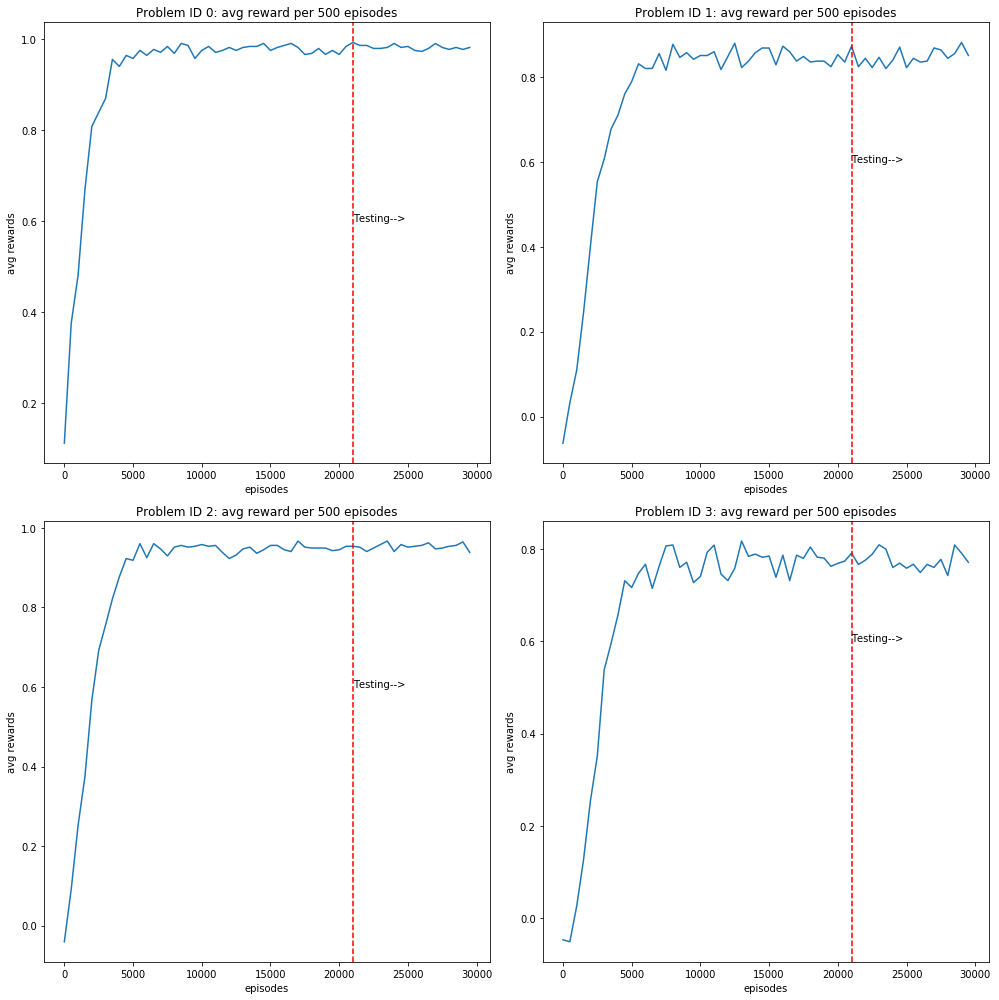

In [96]:
testing_phase=int(max_episodes-0.3*max_episodes)
fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(14,14))

ax[0,0].plot(list(range(0,max_episodes,500)),reward_df[0])
ax[0,0].set_xlabel("episodes")
ax[0,0].set_ylabel("avg rewards")
ax[0,0].axvline(testing_phase,color='r', linestyle='--')
ax[0,0].text(21000,0.6,"Testing-->")
ax[0,0].set_title("Problem ID 0: avg reward per 500 episodes")

ax[0,1].plot(list(range(0,max_episodes,500)),reward_df[1])
ax[0,1].set_xlabel("episodes")
ax[0,1].set_ylabel("avg rewards")
ax[0,1].text(21000,0.6,"Testing-->")
ax[0,1].axvline(testing_phase,color='r', linestyle='--')

ax[0,1].set_title("Problem ID 1: avg reward per 500 episodes")

ax[1,0].plot(list(range(0,max_episodes,500)),reward_df[2])
ax[1,0].set_xlabel("episodes")
ax[1,0].set_ylabel("avg rewards")
ax[1,0].text(21000,0.6,"Testing-->")
ax[1,0].axvline(testing_phase,color='r', linestyle='--')

ax[1,0].set_title("Problem ID 2: avg reward per 500 episodes")

ax[1,1].plot(list(range(0,max_episodes,500)),reward_df[3])
ax[1,1].set_xlabel("episodes")
ax[1,1].set_ylabel("avg rewards")
ax[1,1].text(21000,0.6,"Testing-->")
ax[1,1].axvline(testing_phase,color='r', linestyle='--')

ax[1,1].set_title("Problem ID 3: avg reward per 500 episodes")
        
plt.tight_layout()

# Random Agent:


In [97]:

def randomAgent(max_episode, max_iter_per_episode,problem_id,map_name_base,reward_hole,reward):   
    env = LochLomondEnv(problem_id=problem_id, is_stochastic=False, map_name_base=map_name_base, reward_hole=reward_hole,reward=reward)


    # Reset the random generator to a known state (for reproducibility)
    np.random.seed(0)

    flag=0
    
    goal_count=0 #to check how many goals acieved for all episodes combined
    hole_count=0 #to check how many holes the agent fell into for all episodes combined
    
    episode_count=1
    reward_per_episode=[]
    
    reward_sum=0

    #### Run a random/senseless agent
    for e in range(max_episodes): # iterate over episodes
        observation = env.reset() # reset the state of the env to the starting state     

        for iter in range(max_iter_per_episode):
                
            action = env.action_space.sample() # random sampling of actions
            observation, reward, done, info = env.step(action) #based on random action, it will change states

          # 

          #print("e,iter,reward,done =" + str(e) + " " + str(iter)+ " " + str(reward)+ " " + str(done))

          # Check if we are done and monitor rewards etc...
            
            reward_sum+=reward
            
            if (done and reward == 1):
                goal_count+=1    
                break
            elif (done and reward==reward_hole):
                hole_count+=1
                break
        if episode_count==500:
            reward_per_episode.append(reward_sum/episode_count)
            reward_sum=0
            episode_count=0

        episode_count+=1
        
    accuracy=(goal_count/(goal_count+hole_count)) *100
    
    return accuracy, reward_per_episode



## Problem ID: 0

In [98]:
accuracy_random=[] #to be used for bar plots

In [99]:
problem_id=0
map_name_base='4x4-base'
reward_hole=-0.1
reward=1
max_epsiode=30000
max_iter_per_episode=200

accuracy_random_0, reward_per_episode_random_0=randomAgent(max_epsiode,max_iter_per_episode,problem_id,map_name_base,reward_hole,reward)

accuracy_random.append(accuracy_random_0)

## Problem ID: 1

In [100]:
problem_id=1
map_name_base='4x4-base'
reward_hole=-0.1
reward=1
max_epsiode=30000
max_iter_per_episode=200

accuracy_random_1, reward_per_episode_random_1=randomAgent(max_epsiode,max_iter_per_episode,problem_id,map_name_base,reward_hole,reward)

accuracy_random.append(accuracy_random_1)

## Problem ID: 2

In [101]:
problem_id=2
map_name_base='4x4-base'
reward_hole=-0.1
reward=1
max_epsiode=30000
max_iter_per_episode=200

accuracy_random_2, reward_per_episode_random_2=randomAgent(max_epsiode,max_iter_per_episode,problem_id,map_name_base,reward_hole,reward)

accuracy_random.append(accuracy_random_2)

## Problem ID: 3

In [102]:
problem_id=3
map_name_base='4x4-base'
reward_hole=-0.1
reward=1
max_epsiode=30000
max_iter_per_episode=200

accuracy_random_3, reward_per_episode_random_3=randomAgent(max_epsiode,max_iter_per_episode,problem_id,map_name_base,reward_hole,reward)

accuracy_random.append(accuracy_random_3)

### average rewards gained per 500 episode by Random agent has been stored in reward_array_random:

In [103]:
reward_array_random=np.empty((3,3))
reward_array_random=np.vstack((reward_per_episode_random_0,reward_per_episode_random_1,reward_per_episode_random_2,reward_per_episode_random_3))


avg_reward_random=np.mean(reward_array_random,0) #taking mean of all the problem ids


Text(0,0.5,'avg rewards')

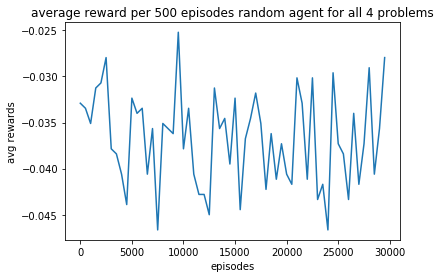

In [104]:
plt.plot(list(range(0,max_episodes,500)),avg_reward_random)
plt.title("average reward per 500 episodes random agent for all 4 problems")
plt.xlabel("episodes")
plt.ylabel("avg rewards")

# Simple Agent:

In [105]:
def my_best_first_graph_search_for_vis(problem, f):
    """
    This explains the standard A star operation. It examines which of the child nodes have the lowest f value and
    that child node becomes the next node. Whenever the agent steps on a node, it adds that node to the explored list. 
    This list will help to trace the path back from goal to start. Also, all the expanded nodes are added to a frontier list 
    and if the child node is already there, its f cost and parent is
    re-evaluated if found lesser than the previous path. Following this procedure, the agent reaches the goal. 
    
    """
    
    # we use these two variables at the time of visualisations
    iterations = 0
        
    f = memoize(f, 'f')
    node = Node(problem.initial)
    iterations += 1
    
    
    if problem.goal_test(node.state):  #if node is goal, it returns the node with the iterations it took
        iterations += 1
        return(iterations, node)
    
    frontier = PriorityQueue('min', f)  #a priority queue to store the node it is visiting and add the child nodes
                                        #in the order of ascending f, so a node will be dequeued first which has minimum f
    frontier.append(node)               #adding the current node to frontier
    iterations += 1
    explored = set()                    #initializing the explored list/set which will contain checked nodes which the agent
                                        #doesn't need to visit again.
    
    while frontier:                     #until frontier is not empty
        node = frontier.pop()           #immediately pop the current node which will got to the checked/ explored set
        iterations += 1
        if problem.goal_test(node.state): #checking if the node is the goal
            iterations += 1
            return(iterations, node)
        
        explored.add(node.state)         #the node is added to the explored set
        for child in node.expand(problem):              #expanding the checked node's children nodes
            if child.state not in explored and child not in frontier: #if child node hasn't been seen ever
                frontier.append(child)                #adding the child node to frontier priority queue for future checking
                iterations += 1                        
            elif child in frontier:                 #if child node was already in the frontier, checking if the cost to
                                                     #reach this node is better than the previous 
                incumbent = frontier[child]         #previous cost
                if f(child) < f(incumbent):        #if found better, delete the previous cost entry from frontier
                    del frontier[incumbent]
                    frontier.append(child)        #and add the new calculated cost as an entry in the priority queue with the new parent
                                                    #this will help to know shortest routes 
                    iterations += 1
        
        iterations += 1
        
    return None


def my_astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h') #h is heuristic distance to goal
    iterations, node = my_best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n)) #f=g+h
    return(iterations,  node)


def env2statespace(env):
    """ 
    This is creating the maze for us by taking the Lochlomond environment. It is returning the locations of every state, 
    the possible directions an agent can move from any state, initial state and final state. also, 
    the holes are directly ignored i.e. the agent doesn't take holes into consideration.
    

    Input:
        env: an Open AI Env follwing the std in the FrozenLake-v0 env

    Output:
        state_space_locations : a dict with the available states
        state_space_actions   : a dict of dict with available actions in each state
        state_start_id        : the start state
        state_goal_id         : the goal state  

      
    """
    state_space_locations = {} # create a dict
    for i in range(env.desc.shape[0]):
        for j in range(env.desc.shape[1]):   
            if not (b'H' in env.desc[i,j]):  #ignoring the holes
                state_id = "S_"+str(int(i))+"_"+str(int(j) ) #dictionay key for state locations
                state_space_locations[state_id] = (int(i),int(j))   #dictionary of key-coordinate
                if env.desc[i,j] == b'S':            # starting point
                    state_initial_id = state_id                                                 
                elif env.desc[i,j] == b'G':        # the goal
                    state_goal_id = state_id                      

                #-- Generate state / action list --#
                # First define the set of actions in the defined coordinate system             
                actions = {"west": [-1,0],"east": [+1,0],"north": [0,+1], "south": [0,-1]} #this will form our action space
                state_space_actions = {}
                for state_id in state_space_locations:      #for every location in state_space_location on the maze, we find out the possible actions                                 
                    possible_states = {}
                    for action in actions:
                        #-- Check if a specific action is possible --#
                        delta = actions.get(action)
                        state_loc = state_space_locations.get(state_id)
                        state_loc_post_action = [state_loc[0]+delta[0],state_loc[1]+delta[1]]

                        #-- Check if the new possible state is in the state_space, i.e., is accessible --#
                        state_id_post_action = "S_"+str(state_loc_post_action[0])+"_"+str(state_loc_post_action[1])                        
                        if state_space_locations.get(state_id_post_action) != None:
                            possible_states[state_id_post_action] = 1 
                        
                    #-- Add the possible actions for this state to the global dict --#                              
                    state_space_actions[state_id] = possible_states

    return state_space_locations, state_space_actions, state_initial_id, state_goal_id


state_space_locations, state_space_actions, state_initial_id, state_goal_id = env2statespace(env)



In [106]:
# Setup the parameters for the specific problem (you can change all of these if you want to) 
problem_id = 1        # problem_id \in [0:7] generates 8 diffrent problems on which you can train/fine-tune your agent 
reward_hole = 0.0     # Holes ignored
is_stochastic = False  # should be False for A-star (deterministic search) and True for the RL agent





def simpleAgent( problem_id,map_name_base):   
    env = LochLomondEnv(problem_id=problem_id, is_stochastic=False, map_name_base=map_name_base)

    



    # Create a dict representation of the state space
    state_space_locations, state_space_actions, state_initial_id, state_goal_id = env2statespace(env)

    # SOLUTION BEGIN
    maze_map = UndirectedGraph(state_space_actions) #creating the maze of Lochlomond 
    maze_map.locations = state_space_locations #locations
    maze_problem = GraphProblem(state_initial_id, state_goal_id, maze_map) 
    print(maze_problem) #the np 2D matrix representing the environment: Lochlomonod 
    # SOLUTION END


    iterations, node = my_astar_search_graph(problem=maze_problem, h=None)

    #-- Trace the solution --#
    solution_path = [node]       
    cnode = node.parent
    solution_path.append(cnode)
    while cnode.state != state_initial_id: #until current_node is not equal to starting point, keep tracing
        cnode = cnode.parent  
        solution_path.append(cnode)


    return iterations, solution_path

## Problem ID: 0

In [107]:
iterations_0, solution_path_0= simpleAgent( problem_id=0,map_name_base='4x4-base')

## Problem ID: 1

In [108]:
iterations_1, solution_path_1= simpleAgent( problem_id=1,map_name_base='4x4-base')


## Problem ID:2

In [109]:
iterations_2, solution_path_2= simpleAgent( problem_id=2,map_name_base='4x4-base')

## Problem ID: 3

In [110]:
iterations_3, solution_path_3= simpleAgent( problem_id=3,map_name_base='4x4-base')

In [111]:
mean_iteration_simple=int((iterations_0+iterations_1+iterations_2+iterations_3)/4)
print("Average, over all problem ids, number of iterations required by the agent to attain goal node: ",mean_iteration_simple)

Average, over all problem ids, number of iterations required by the agent to attain goal node:  24


## Reward will always be 1 for Simple agent since it always reaches the goal after finding it.

# Overall comparison of 3 agents accross 4 problem IDs:

The point of convergence for the RL agent is  5500


Text(5500,0.3,'4500')

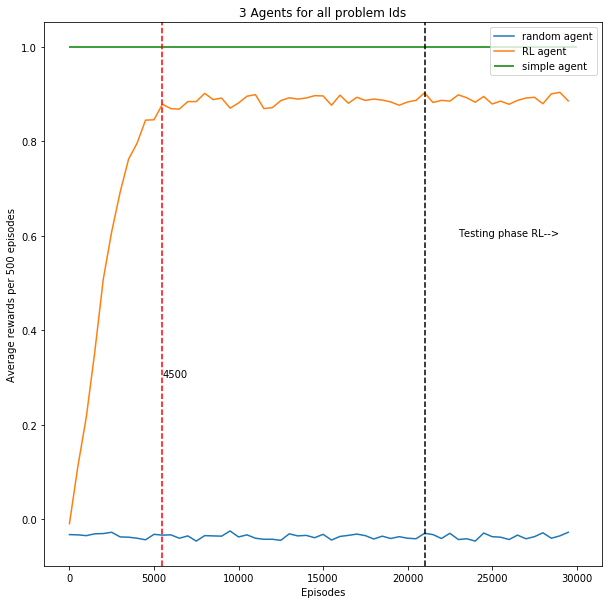

In [112]:
fig=plt.figure(figsize=(10,10))
plt.plot(list(range(0,max_episodes,500)),avg_reward_random, label='random agent')
plt.plot(list(range(0,max_episodes,500)),avg_reward_rl, label='RL agent')

plt.hlines(1, 0,max_episodes, 'g',label='simple agent')
plt.title("3 Agents for all problem Ids")
plt.ylabel("Average rewards per 500 episodes")
plt.xlabel("Episodes")
plt.axvline(testing_phase,color='k', linestyle='--')
plt.text(23000,0.6,"Testing phase RL-->")
plt.legend(loc=0)


converge_point = KneeLocator(range(0,max_episodes,500), avg_reward_rl, direction='increasing') #knee locator
print("The point of convergence for the RL agent is ",converge_point.knee)
plt.axvline(converge_point.knee,color='r',linestyle='--')
plt.annotate('4500',xy=(converge_point.knee,0.3),xytext=(converge_point.knee,0.3))

## Accuracy table

In [113]:
accuracy_agents_df=pd.DataFrame()
accuracy_agents_df['random agent']=accuracy_random
accuracy_agents_df['RL agent']=accuracy_rl
accuracy_agents_df['simple agent']=[100 for i in range(0,4)]
accuracy_agents_df

,random agent,RL agent,simple agent
0,13.660000,98.444444,100
1,2.513333,86.101846,100
2,4.443333,95.722222,100
3,2.380000,79.786049,100
